# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook one - Sampling technique

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agrawal -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

This notebook is based on De Prado, "Advances in Financial Machine Learning" book. The idea is that the characteristics of financial time series sample data can be improved if we use sampling techniques other that time sampling. In this case we use "tick" sampliand and an approximation of "dollar" sampling. As an example we will use the data for AUD/USD pair for the last 4 years.

In [1]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..') # r'C:\WQU\Capstone\Working_files'
sys.path.append(path_to_project)

In [2]:
import pandas as pd
import numpy as np
import datetime as dt

In [3]:
import warnings
warnings.filterwarnings('ignore')

We packed the main part of the code into a library below for this project.

In [4]:
from WQUcapstoneCode.sampling import sampling

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [6]:
save=True
ticker = 'AUD/USD'
input_path = os.path.join(path_to_project, 'input_data', ''.join(ticker.split('/')) + '.csv')
token = 'PLEASE CREATE YOUR TOKEN' # https://www.fxcm.com/fxcmpy

In [7]:
try:
    import fxcmpy
    con = fxcmpy.fxcmpy(access_token=token, log_level='error')
    #cannot download everything in one go because FXCM api rerurns only a limited number of records so we split them in two time periods
    start = dt.datetime(2015, 6, 1)
    end = dt.datetime(2017, 6, 1)
    pair = con.get_candles(ticker1, period='H2', start=start, end=end)

    start = end
    end = dt.datetime(2020, 6, 1)  
    pair = pair.append(con.get_candles(ticker, period='H2', start=start, end=end))

    if save: pair.to_csv(os.path.join(input_path))

except:
    print("Reading the data offline")
    pair = pd.read_csv(input_path)
print(f'We have a total of {pair.shape[0]} records in the input data for {ticker}')

Reading the data offline
We have a total of 19050 records in the input data for AUD/USD


In [8]:
pd.concat([pair.head(3), pair.tail(3)]) # top and bottom 3 

,date,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty
0,2014-06-22 23:00:00,0.93839,0.94247,0.93913,0.93832,0.93849,0.94259,0.93925,0.93842,2871
1,2014-06-23 01:00:00,0.93861,0.94363,0.94432,0.93840,0.93871,0.94373,0.94443,0.93851,13471
2,2014-06-23 03:00:00,0.94363,0.94396,0.94411,0.94341,0.94373,0.94407,0.94418,0.94353,4216
19047,2020-06-22 19:00:00,0.69168,0.69076,0.69170,0.69012,0.69178,0.69093,0.69181,0.69024,14731
19048,2020-06-22 21:00:00,0.69076,0.69228,0.69248,0.69005,0.69093,0.69240,0.69256,0.69050,9471
19049,2020-06-22 23:00:00,0.69228,0.69213,0.69346,0.69167,0.69240,0.69226,0.69358,0.69177,20808


We will be working with the mid price and tick number. While we don't have volume and dollar volume per se, we can try to "model" the dollar volume by multiplying the mid price by the number of ticks. The disclaimer here is that we recognise that each tick may have different volume, it's just hard to get the volume data.

In [22]:
df = pd.DataFrame()
df['price'] = np.mean(pair[['bidclose','askclose']], axis = 1)
df['ticks'] = pair['tickqty']
df.index =[dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in pair.date]
    
#let's assume that price x ticks is an approximation for dollar volume
df['dv'] = df.price * df.ticks

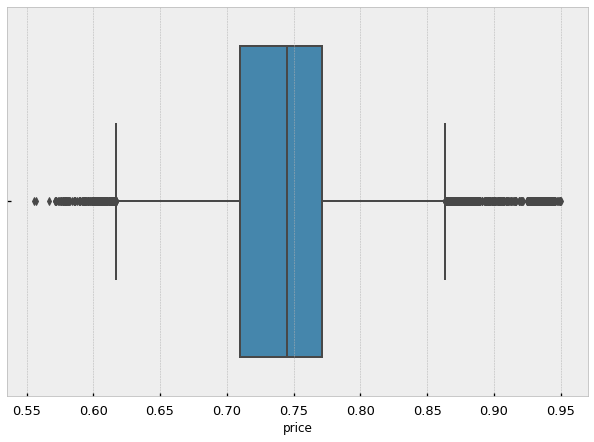

In [10]:
sns.boxplot(df.price, )

As can be seen from the above, there are no large outliers so there's no need to clean this data.
Now when we have the data we may try to inprove it's characteristics by using a sampling technoque different from time sampling.

In [34]:
ticks_multiplier = 2. # for calculating average number of ticks/dollars exchanged in 4 hour intervals  (2 hour interval is original data)
m_ticks = ticks_multiplier * df.ticks.sum()/df.shape[0] # average number of ticks in 4 hour interval
m_dollars = ticks_multiplier * df.dv.sum()/df.shape[0] # average number of dollars exchanged in 4 hour interval

#print(m_ticks,m_dollars)

31278.887349081364 23150.625202953805


In [12]:
tick_df = sampling.sampled_bar_df(df, 'ticks',m_ticks)
dollar_df = sampling.sampled_bar_df(df, 'dv',m_dollars)

100%|██████████| 19050/19050 [00:00<00:00, 1255542.85it/s]


In [13]:
print(f"""Number of variables in a sample
Time bar:   {df.shape[0]:,}
Tick bar:   {tick_df.shape[0]:,}
Dollar bar: {dollar_df.shape[0]:,}
""")

Number of variables in a sample
Time bar:   19,050
Tick bar:   7,118
Dollar bar: 7,147



Now let's plot the last 255 intervals for time bars and the corresponding tick and dollar bars in that interval

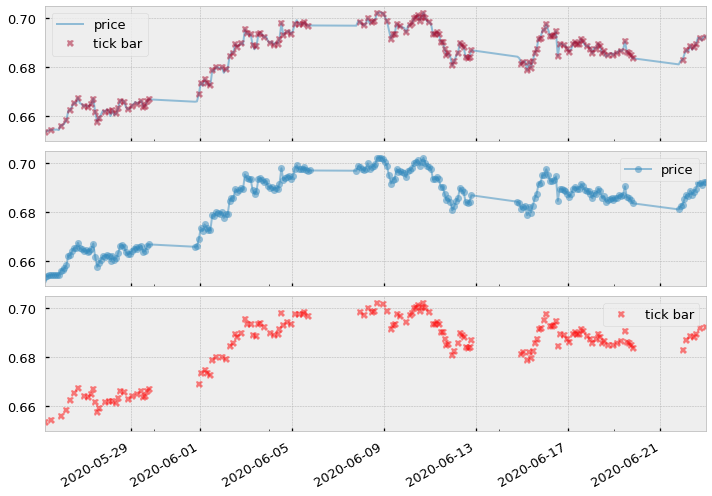

In [46]:
#last 255 intervals for time bars and the corresponding tick bars in that interval

intervals_to_plot = 255
xdf, xtdf = sampling.select_sample_data(df, tick_df, 'price', start_date = df.index[-intervals_to_plot-1], end_date = df.index[-1])

#print(xdf.shape[0], xtdf.shape[0])

sampling.plot_sample_data(xdf, xtdf, 'tick bar', alpha=0.5, markersize=7)

255 149


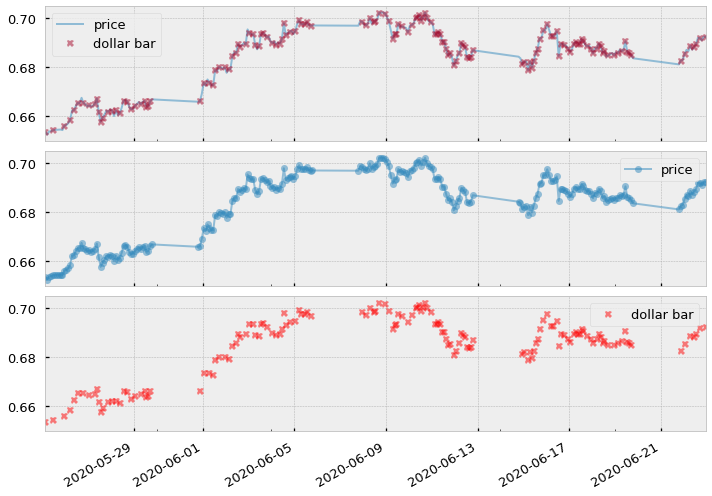

In [49]:
#last 255 intervals for time bars and the corresponding dollar bars in that interval

xdf, xddf = sampling.select_sample_data(df, dollar_df, 'price', start_date = df.index[-intervals_to_plot-1], end_date = df.index[-1])
#print(xdf.shape[0], xddf.shape[0])

sampling.plot_sample_data(xdf, xddf, 'dollar bar', alpha=0.5, markersize=7)

In [50]:
bar_returns = sampling.returns(df.price), sampling.returns(tick_df.price), sampling.returns(dollar_df.price)
bar_types = ['time','tick', 'dollar']


Below are the tables autocorrelation and absolute autocorrelation statistics

In [51]:
autocorrs = sampling.get_test_stats(bar_types,bar_returns,pd.Series.autocorr)
display(autocorrs.sort_values('autocorr_stat'),
        autocorrs.abs().sort_values('autocorr_stat'))

,sample_size,autocorr_stat
time,19049.0,-0.019891
dollar,7146.0,-0.004029
tick,7117.0,-0.003635


,sample_size,autocorr_stat
tick,7117.0,0.003635
dollar,7146.0,0.004029
time,19049.0,0.019891


Autocorrelation drops with number of lags for both tick and dollar samples. However, looking at charts below, we can see that some lags actually have higher autocorrelation.

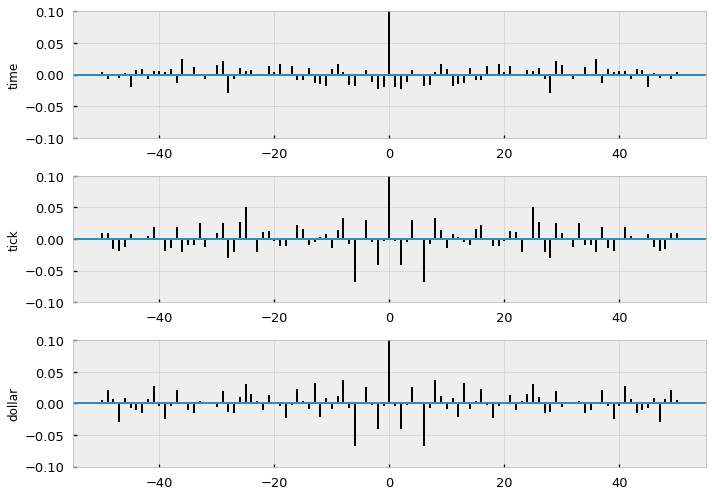

In [18]:
sampling.plot_autocorr(bar_types,bar_returns, ylim = [-0.1,0.1])

Now we can check if the distribution of the returns is closer to normal

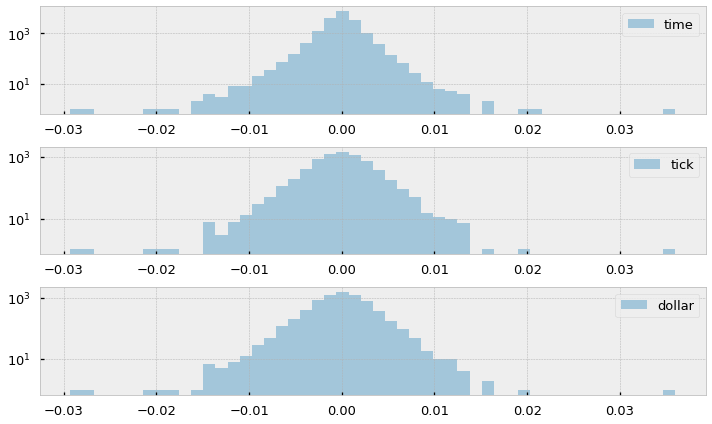

In [19]:
sampling.plot_hist(bar_types,bar_returns)

Jarque-Bera Test (smaller - closer to normal):

In [20]:
sampling.get_test_stats(bar_types,bar_returns,sampling.jb)

,sample_size,jb_stat
time,19049.0,318311.516006
tick,7117.0,14051.759217
dollar,7146.0,14648.545094


Shapiro-Wilk Test (larger - closer to normal):

In [21]:
sampling.get_test_stats(bar_types,bar_returns,sampling.shapiro)

,sample_size,shapiro_stat
time,19049.0,0.889983
tick,7117.0,0.956395
dollar,7146.0,0.955143


Both Jarque-Bera and Shapiro-Wilk Test have shown that tick and dollar sampling have have made the distribution of returns closer to normal

### Conclusion
The evidence above has shown that it is better to use tick and dollar sampling instead of time sampling. 
The difference between tick and dollar sampling in our case is small. Since our dollar sampling does not take volumes into account in the most accurate manner and tick sampling has more favorable statistics, we will proceed with tick sampling.